<font size=6>**Fitting Methods and Interpolation**</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from astropy.table import Table
from scipy.stats import truncnorm
from sklearn import neighbors

%matplotlib inline

# Ordinary Least Squares (OLS)

You likely have seem least squares in the past - it is possibly the simplest thing one can do: fit a straight line to a bunch of data. We parameterize the line with a slope $m$ and intercept $b$, and you may have come across the OLS equation for the optimum values:

$$ m = \frac{\sum_{i=1}^N (x_i - \bar{x}) (y_i - \bar{y}) }{\sum_{i=1}^N (x_i-\bar{x})^2} $$

$$ b = \bar{y} - m \bar{x} $$

In [2]:
def calc_OLS(x, y):
    """Calculate the ordinary least squares fit to data.
    
    Arguments
    ---------
    x : numpy array
        The list of independent variables
    y : numpy array
        The list of dependent variables
        
    Returns
    -------
    m : float
        Slope of the best-fit line
    b : float
        Intercept of the best_fit line
    """
    
    
    x_avg = np.mean(x)
    y_avg = np.mean(y)
    
    m = np.sum((x-x_avg) * (y-y_avg)) / np.sum((x-x_avg)**2)
    b = y_avg - m * x_avg
    
    return m, b



In [3]:
# First we use astropy tables to load the data, which we obtained directly from CDS

readme = './data/ReadMe'
RR_lyrae_table2 = Table.read('./data/table2.dat', readme=readme, format='cds')

# We will select just the 'FU' type RR Lyraes
RR_lyrae = RR_lyrae_table2[np.where(RR_lyrae_table2['Mode'] == 'RRab')]

# Now remove sources V20 and V21 due to blending
RR_lyrae = RR_lyrae[np.where(RR_lyrae['ID'] != 'V20')[0]]
RR_lyrae = RR_lyrae[np.where(RR_lyrae['ID'] != 'V21')[0]]

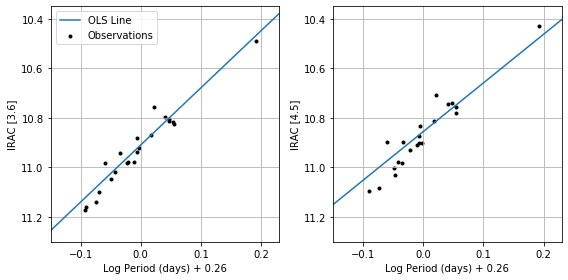

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Axis limits
for a in ax:
    a.set_ylim(11.3, 10.35)
    a.set_xlim(-0.15, 0.23)
    a.set_xticks([-0.1, 0.0, 0.1, 0.2])

# Plot 3.6 micron data
ax[0].scatter(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], color='k', marker='.', label='Observations')

tmp_x = np.linspace(-0.15, 0.23, 10)
m, b = calc_OLS(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'])
ax[0].plot(tmp_x, m*tmp_x+b, label='OLS Line')


# Plot 4.5 micron data
ax[1].scatter(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], color='k', marker='.')

tmp_x = np.linspace(-0.15, 0.23, 10)
m, b = calc_OLS(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'])
ax[1].plot(tmp_x, m*tmp_x+b)

ax[0].legend()

# Plot labels
for a in ax:
    a.set_xlabel('Log Period (days) + 0.26')
    a.grid()
    
ax[0].set_ylabel('IRAC [3.6]')
ax[1].set_ylabel('IRAC [4.5]')

plt.tight_layout()
plt.show()

### It seems we've done a good job, but what have we left out?

<details>
<summary><b>[Spoiler]</b></summary>
<br>
This approach does not take into account error bars on the data!
<br>

To improve things, let's return to the linear algebra approach we saw earlier this morning. We first define our matrices so our data satisfy the equation $Y = A X$. 

$$
A = \begin{bmatrix}
b \\
m
\end{bmatrix}
$$

$$ Y = \left[ 
             \begin{matrix} 
                y_1 \\
                y_2 \\
                \vdots \\
                y_N
             \end{matrix}
    \right] 
$$

$$ X = 
    \begin{bmatrix} 
        1 & x_1 \\
        1 & x_2 \\
        \vdots & \vdots \\
        1 & x_N
    \end{bmatrix}
$$


If we had no error bars on the data, we could directly solve for $A$:

$$ Y = X A $$

$$ X^T Y = X^T X A $$

$$ A = (X^T X)^{-1} X^T Y $$

If you go through the calculation, you will find that this result for $A$ is identical to the OLS result above. Just to prove it, we'll perform the calculation and compare to our previous equation for the OLS fit.

In [5]:
def calc_OLS_linear_algebra(x, y):
    """Calculate the ordinary least squares fit to data.
    
    Arguments
    ---------
    x : numpy array
        The list of independent variables
    y : numpy array
        The list of dependent variables
        
    Returns
    -------
    m : float
        Slope of the best-fit line
    b : float
        Intercept of the best_fit line
    """
    
    Y = np.matrix(y).T                              # The y-values
    N = Y.size                                      # The number of observations

    X = np.ones((N, 2))                             # Create a 2xN matrix of 1's
    X[:,1] = x                                      # Set the second row to the x-values
    X = np.matrix(X)                                # Convert numpy array to a numpy matrix
    
    A = inv(X.T * X) * (X.T * Y)                    # Our solution vector

    return np.array(A)                              # Convert back from numpy matrix to numpy array


# We need to remove stars that don't have data in the [3.6] micron band
idx = np.where(np.array(RR_lyrae['[3.6]']) != 0)[0]
A = calc_OLS_linear_algebra(RR_lyrae['logP'][idx]+0.26, RR_lyrae['[3.6]'][idx])

m, b = calc_OLS(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'])

print("OLS linear algebra approach:", A)
print("Traditional OLS equations:", b, m)

OLS linear algebra approach: [[10.91571509]
 [-2.369672  ]]
Traditional OLS equations: 10.909197257656432 -2.303614777521792


### So, how do we add error bars? 

We include the covariance matrix C:

$$ C = 
    \begin{bmatrix} 
        \sigma^2_{y_1} & 0 & \dots & 0 \\
        0 & \sigma^2_{y_2} & \dots & 0 \\
        \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & \dots & \sigma^2_{y_N}
    \end{bmatrix}
$$

There will be more on this later this afternoon. For now, we will assume independent observations, so the covariance matrix only has diagonal elements. Now, we can rederive the solution for the best fit $A$. First we take our linear equation and left-multiply it by the inverse of the covariance matrix


$$
C^{-1} Y = C^{-1} X A
$$

Next, we left-multiply by X transpose

$$
X^T C^{-1} Y = X^T C^{-1} X A
$$

As a last step, we want to solve for $A$, so we left-multiply each side by $\left[ A^T C^{-1} A \right]^{-1}$ obtaining the simple result:

$$ A =
\left[ X^T C^{-1} X \right]^{-1} \left[ X^T C^{-1} Y \right]
$$

We can use the function from earlier this morning to calculate this result:

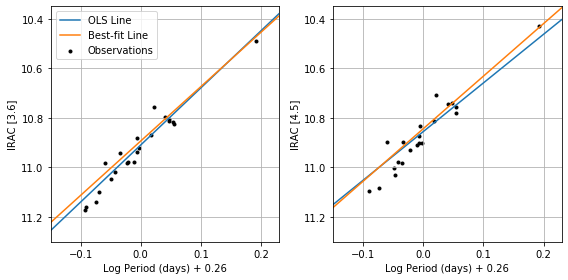

In [6]:
def calc_best_fit(data_x, data_y, data_y_err):
    """ Calculate the best fit line values """
    
    Y = np.matrix(data_y).T                         # The y-values
    N = Y.size                                      # The number of observations

    X = np.ones((N, 2))                             # Create a 2xN matrix of 1's
    X[:,1] = data_x                                 # Set the second row to the x-values
    X = np.matrix(X)                                # Convert numpy array to a numpy matrix

    C = np.identity(N) * data_y_err                 # Create the covariance matrix
    C = np.matrix(C)                                # Convert numpy array to a numpy matrix

    A = inv(X.T * inv(C) * X) * (X.T * inv(C) * Y)  # Our solution vector
    
    return np.array(A)                              # Convert back from numpy matrix to numpy array


fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Axis limits
for a in ax:
    a.set_ylim(11.3, 10.35)
    a.set_xlim(-0.15, 0.23)
    a.set_xticks([-0.1, 0.0, 0.1, 0.2])

# Plot 3.6 micron data
ax[0].scatter(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], color='k', marker='.', label='Observations')

tmp_x = np.linspace(-0.15, 0.23, 10)
m, b = calc_OLS(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'])
ax[0].plot(tmp_x, m*tmp_x+b, label='OLS Line')
b, m = calc_best_fit(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]'])
ax[0].plot(tmp_x, m*tmp_x+b, label='Best-fit Line')


# Plot 4.5 micron data
ax[1].scatter(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], color='k', marker='.')

tmp_x = np.linspace(-0.15, 0.23, 10)
m, b = calc_OLS(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'])
ax[1].plot(tmp_x, m*tmp_x+b)
b, m = calc_best_fit(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], RR_lyrae['e_[4.5]'])
ax[1].plot(tmp_x, m*tmp_x+b)

ax[0].legend()

# Plot labels
for a in ax:
    a.set_xlabel('Log Period (days) + 0.26')
    a.grid()
    
ax[0].set_ylabel('IRAC [3.6]')
ax[1].set_ylabel('IRAC [4.5]')

plt.tight_layout()
plt.show()

### There is a slight difference between the OLS solution and best-fit line including the covariance. Discuss with your partner why that might be the case


<details>
<summary><b>[Spoiler]</b></summary>
<br>
The error bars on the data points are not all the same. There are some slight differences, so different points will be weighted a different amount. 

Some fun vocabulary:
Homoscedastic: Data in which every data point has the same size uncertainty
Heteroscedastic: Data in which every data point has its own uncertainty
<br>

### Expanding to higher order solutions

The linear algebra approach allows us to extend our fitting solution to an arbitrarily large order polynomial:

$$ y = a_0 + a_1x + a_2x^2 + ... + a_m  x^m $$

This is as easy as expanding the length of $A$:
$$
A = \begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
a_m
\end{bmatrix}
$$

and expanding our $X$ matrix:

$$ X = 
    \begin{bmatrix} 
        1 & x_1 & \dots & x_1^m \\
        1 & x_2 & \dots & x_2^m \\
        \vdots & \vdots & \ddots & \vdots \\
        1 & x_N & \dots & x_N^m
    \end{bmatrix}
$$

The solution to the linear algebra equation is the same, we just need to construct our function so it can flexibly take in the polynomial degree we are trying to fit

In [7]:
def calc_best_fit(data_x, data_y, data_y_err, degree=1):
    """ Calculate the best fit line values """
    
    Y = np.matrix(data_y).T                         # The y-values
    N = Y.size                                      # The number of observations

    X = np.ones((N, degree+1))                      # Create a mxN matrix of 1's
    
    for i in range(degree+1):
        X[:,i] *= data_x**i                         # Set each row to the degree polynomial of x-values
    X = np.matrix(X)                                # Convert numpy array to a numpy matrix

    C = np.identity(N) * data_y_err                 # Create the covariance matrix
    C = np.matrix(C)                                # Convert numpy array to a numpy matrix
    
    A = inv(X.T * inv(C) * X) * (X.T * inv(C) * Y)  # Our solution vector
    
    return np.array(A)                              # Convert back from numpy matrix to numpy array


def calc_uncertainties(data_x, data_y_err, degree=2):
    """ Calculate uncertainties on these values """
    
    N = len(data_x)                                 # The number of observations
    
    X = np.ones((N, degree+1))                       # Create a 2xN matrix of 1's
    for k in range(degree+1):
        X[:,k] = data_x**k                          # Set the second row to the x-values
    X = np.matrix(X)
    
    C = np.identity(N) * data_y_err                 # Create the covariance matrix
    C = np.matrix(C)                                # Convert numpy array to a numpy matrix

    cov = inv(X.T * inv(C) * X)                     # Calculate the uncertainties

    return np.array(cov)


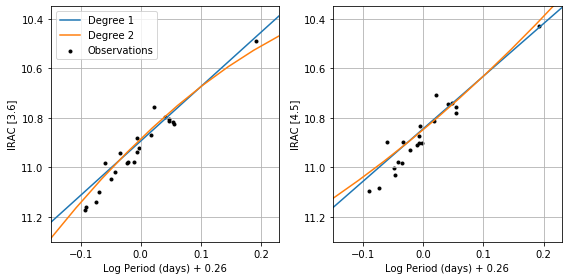

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Axis limits
for a in ax:
    a.set_ylim(11.3, 10.35)
    a.set_xlim(-0.15, 0.23)
    a.set_xticks([-0.1, 0.0, 0.1, 0.2])

# Plot 3.6 micron data
ax[0].scatter(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], color='k', marker='.', label='Observations')

tmp_x = np.linspace(-0.15, 0.23, 10)
a = calc_best_fit(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]'], degree=1)
tmp_y = np.zeros(len(tmp_x))
for i in range(len(a)):
    tmp_y += a[i] * tmp_x**i
ax[0].plot(tmp_x, tmp_y, label='Degree 1')
a = calc_best_fit(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]'], degree=2)
tmp_y = np.zeros(len(tmp_x))
for i in range(len(a)):
    tmp_y += a[i] * tmp_x**i
ax[0].plot(tmp_x, tmp_y, label='Degree 2')


# Plot 4.5 micron data
ax[1].scatter(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], color='k', marker='.')

tmp_x = np.linspace(-0.15, 0.23, 10)
a = calc_best_fit(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], RR_lyrae['e_[4.5]'], degree=1)
tmp_y = np.zeros(len(tmp_x))
for i in range(len(a)):
    tmp_y += a[i] * tmp_x**i
ax[1].plot(tmp_x, tmp_y)
a = calc_best_fit(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], RR_lyrae['e_[4.5]'], degree=2)
tmp_y = np.zeros(len(tmp_x))
for i in range(len(a)):
    tmp_y += a[i] * tmp_x**i
ax[1].plot(tmp_x, tmp_y)

ax[0].legend()

# Plot labels
for a in ax:
    a.set_xlabel('Log Period (days) + 0.26')
    a.grid()
    
ax[0].set_ylabel('IRAC [3.6]')
ax[1].set_ylabel('IRAC [4.5]')

plt.tight_layout()
plt.show()

### A deeper discussion about OLS

Discuss with your partner in what regimes OLS breaks down


<details>
<summary><b>[Spoiler]</b></summary>
<br>
Here are a few:
    1. So far we have assumed the data are uncorrelated. If they are correlated, it can be taken into account, but the covariance matrix will have off-diagonal terms.
    2. OLS breaks down if the x-axis also has error bars. So far, we have assumed errors only on the y-axis.
    3. Outliers can really cause problems for OLS.
<br>

The data here is actually pretty good. To demonstrate just how bad things can get, let's consider different ways of fitting a line to data. This figure is taken from "Linear regression in astronomy" by Isobe et al., 1990.

![title](images/Isobe_fig1.png)

The slope and variance of the slope is defined as:

![title](images/Isobe_fig2.png)

It is important to note that the five methods described here give regression coefficients that are theoretically different from each other, and are not five different estimates of the same quantity. Let's apply this to some data.

In [9]:


# Stolen from https://github.com/sbird/spb_common/blob/master/leastsq.py
def leastsq(x,y, method=3):
    """
       Compute the least squares fit to y = beta x + alpha,
       using one of the 5 methods outlined in
       http://adsabs.harvard.edu/abs/1990ApJ...364..104Is
       Method 1 minimises distance from Y given X (ie, the standard least squares fit)
       Method 2 minimises distance from X given Y
       Method 3 (recommended) is the OLS bisector, which gives a line bisecting the above two.
       Method 4 (Orthogonal regression) minimises perpendicular distance from the line to points
       Method 5 is the geometric mean of the slopes from methods 1 and 2.
       Method 6 is the Theil-Sen estimator: the median of the pairwise slopes.
       (See Akritas 95,  http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476499)
       Returns:
              (alpha, beta, bvar), the intercept slope and variance of the slope
    """
    #Define some sums
    xbar = np.mean(x)
    ybar = np.mean(y)
    xdif = x-xbar
    ydif = y-ybar
    sxx = np.sum(xdif**2)
    syy = np.sum(ydif**2)
    sxy = np.sum(ydif*xdif)

    #Check for zeros
    if sxx == 0 or syy == 0 or sxy == 0:
        raise ValueError("Least Squares ill-defined")
    if method > 6 or method < 1:
        raise ValueError("Method not recognised")

    #These formulas are taken from Table 1 of Isobe et al, page 3
    #Minimise distance from Y given X
    beta1 = sxy/sxx
    #Variance of b1
    bvar1 = np.sum(xdif**2*(ydif-beta1*xdif)**2)/sxx**2
    #Minimise distance from X given Y
    beta2 = syy/sxy
    #Variance of b2
    bvar2 = np.sum(ydif**2*(ydif-beta2*xdif)**2)/sxy**2
    #Covariance of b1 and b2
    covb12 = np.sum(xdif*ydif*(ydif-beta2*xdif)*(ydif-beta1*xdif))/(beta1*sxx**2)

    if method == 1:
        beta = beta1
        bvar = bvar1
    if method == 2:
        beta = beta2
        bvar = bvar2
    if method == 3:
        #OLS bisector: line that bisects the above two.
        beta1p1 = 1+beta1**2
        beta2p1 = 1+beta2**2
        beta = (beta1*beta2 - 1 + np.sqrt(beta1p1*beta2p1))/(beta1+beta2)
        #Variance
        prefac = beta**2 / ( (beta1 + beta2)**2 * beta1p1 * beta2p1)
        var = beta2p1**2 * bvar1 + 2 * beta1p1 * beta2p1 * covb12 + beta1p1**2 * bvar2
        bvar = prefac*var

    if method == 4:
        #Orthogonal: minimise perpendicular distance from line to points
        beta = 0.5*((beta2-1./beta1)+np.sign(sxy)*np.sqrt(4+(beta2-1./beta1)**2))
        prefac = beta**2 / (4*beta1**2 + (beta1*beta2 - 1)**2)
        bvar = prefac * ( bvar1/beta1**2 + 2*covb12 + beta1**2*bvar2 )

    if method == 5:
        #Reduced major axis:
        beta = np.sign(sxy)*np.sqrt(beta1*beta2)
        bvar = 0.25 * (beta2/beta1 * bvar1 + 2*covb12 + beta1/beta2 * bvar2)

    if method == 6:
        #Theil-Sen estimator for uncensored data: the median of the slopes.
        yy = np.subtract.outer(y,y)
        xx = np.subtract.outer(x,x)
        ind = np.where(xx != 0)
        beta = np.median(yy[ind]/xx[ind])
        #Can't find a formula for the variance
        bvar = 0

    #The intercept
    alpha = ybar - beta*xbar

    return (alpha, beta, bvar)

###################  OLS(Y|X)  #######################
Slope = -4.61 ± 1.41
intercept = 57.75
###################  OLS(X|Y)  #######################
Slope = -13.81 ± 9.64
intercept = 78.15
###################  OLS bisector  #######################
Slope = -6.94 ± 1.45
intercept = 62.93
###################  ODR  #######################
Slope = -13.66 ± 9.40
intercept = 77.83
###################  RMA  #######################
Slope = -7.98 ± 1.09
intercept = 65.22


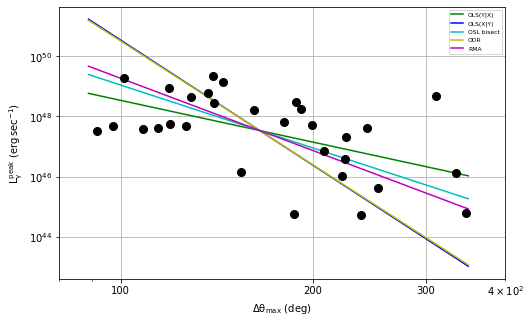

In [10]:
# Load up the data
amp_lum = np.loadtxt('data/Ampl_Lum.dat', comments='#')

rot_ampl = amp_lum[:,0]
lumin    = amp_lum[:,1]

# plotting
figure = plt.figure(figsize=(8.0, 5.0))
figure.subplots_adjust(hspace=0.1)
fig1 = plt.subplot(111)

plt.errorbar(rot_ampl,lumin,xerr=0,yerr=0,color='k', marker='o', markeredgecolor='k',\
             ms=8., capsize=0, linestyle='None', fmt='')


# OLS(Y|X)
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=1)
print("###################  OLS(Y|X)  #######################")
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = 10**(beta * np.log10(x) + alpha)
plt.plot(x,y,c='g',label='OLS(Y|X)')

# OLS(X|Y)
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=2)
print("###################  OLS(X|Y)  #######################")
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = 10**(beta * np.log10(x) + alpha)
plt.plot(x,y,c='b',label='OLS(X|Y)')

# OLS bisector
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=3)
print("###################  OLS bisector  #######################")
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = 10**(beta * np.log10(x) + alpha)
plt.plot(x,y,c='c',label='OSL bisect')

# ODR
# see also https://docs.scipy.org/doc/scipy/reference/odr.html
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=4)
print("###################  ODR  #######################")
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = 10**(beta * np.log10(x) + alpha)
plt.plot(x,y,c='y',label='ODR')

# RMA
alpha, beta, bvar = leastsq(np.log10(rot_ampl),np.log10(lumin),method=5)
print("###################  RMA  #######################")
print("Slope = %.2f ± %.2f"%(beta,bvar))
print("intercept = %.2f"%(alpha))
x = np.linspace(89,350,100)
y = 10**(beta * np.log10(x) + alpha)
plt.plot(x,y,c='m',label='RMA')
plt.legend(prop={'size':6})


plt.xlabel(r'$\mathsf{\Delta \theta_{max}}$ (deg)')
plt.ylabel(r'$\mathsf{L_{\gamma}^{peak}}$ ($\mathsf{erg \, sec^{-1}}$)')

plt.grid()

plt.xlim([80,400])
fig1.set_xscale('log')
fig1.set_yscale('log')
plt.xticks([100,200,300], ['100','200','300'])

plt.show()

## What should we take away from this?

The simple ordinary least-squares analysis taught in statistics classes really isn't so simple, and it hides a lot. This isn't meant to scare you. On the contrary, throughout this week we are going to teach you a lot of techniques that are (hopefully) useful in your everyday research.

As for the example above, if you have a situation where you really are trying to fit a line to data, and you have errors on both the $x$- and $y$-axis, then we recommend using Bayesian methods, which we will be teaching tomorrow. 

# What if we want to interpolate between data?

Interpolation is inherently a flawed procedure. At its core, it requires one to derive a new dependent variable $y'$ from an independent variable or variables, $\vec{x}'$ based on a set of known $\{ \vec{x_0}, y_0, \vec{x_1}, y_1, ..., \vec{x_n}, y_n\}$. The idea that one can derive a new value without having prior theoretical knowledge or empical constraints is bonkers. Yet, it is occasionally -- even often -- unavoidable. Here, we'll discuss some interpolation techniques.


## $k$-Nearest Neighbor Interpolation

This method is exactly what it sounds like: Find a set of $\{ \vec{x}_k \}$ that is close to $\vec{x}'$, and use the associated $\{ y_k \}$ to derive an estimation of $y'$. Depending on the details of this procedure, multiple approaches are possible, with varying levels of complication.

This method is the most simple of them all, but as we'll see below is already fraught with complication when $\vec{x}$ is multi-dimensional.


#### 1. Nearest Neighbor Interpolation
This method is the simplest of them all, simply find the nearest neighbor and adopt that value of $y$ as an estimation of $y'$.

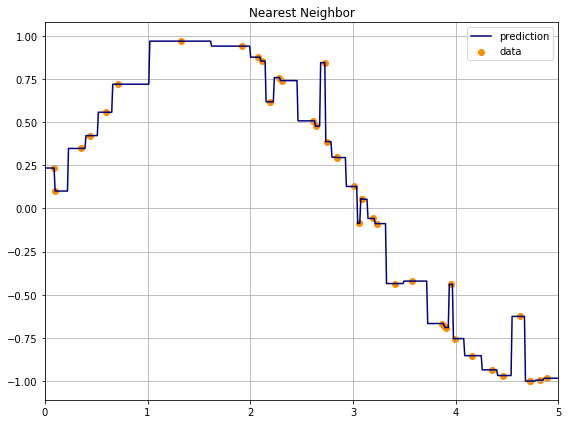

In [11]:
fig = plt.figure(figsize=(8,6))


np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

n_neighbors = 1
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
y_ = knn.fit(X, y).predict(T)

plt.scatter(X, y, color="darkorange", label="data")
plt.plot(T, y_, color="navy", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("Nearest Neighbor")
plt.xlim(0, 5)
plt.grid()

plt.tight_layout()
plt.show()

#### 2. Average of the $k$-nearest neighbors
A clear improvement to the nearest neighbor interpolation technique is to expand to multiple nearest neighbors. This method is denoted $k$-nearest neighbors, where $k$ is the number of nearest neighbors incorporated into the calculation. In its simplest realization, one could adopt the average of the $k$-nearest $y$ values as the value of $y'$.

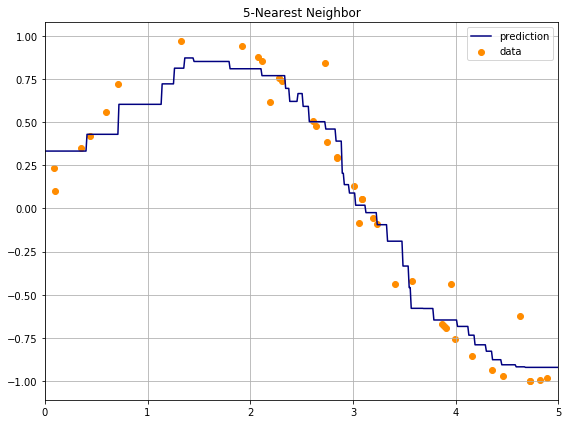

In [12]:
fig = plt.figure(figsize=(8,6))


np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))


n_neighbors = 5
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
y_ = knn.fit(X, y).predict(T)

plt.scatter(X, y, color="darkorange", label="data")
plt.plot(T, y_, color="navy", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("5-Nearest Neighbor")
plt.xlim(0, 5)
plt.grid()
# plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.tight_layout()
plt.show()

#### 3. Weighted average
As a second method, one could add weights to the simple average. How should one choose the weights? Typically these are based on the distance, so closer points are weighted more heavily. Weights could be $1/d$ or even $1/d^2$. 

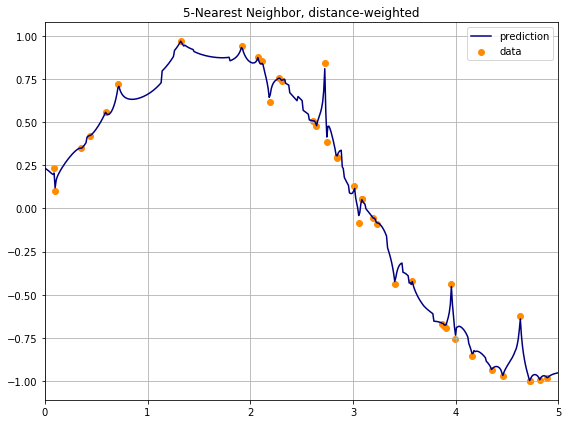

In [13]:
fig = plt.figure(figsize=(8,6))


np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))


n_neighbors = 5
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
y_ = knn.fit(X, y).predict(T)

plt.scatter(X, y, color="darkorange", label="data")
plt.plot(T, y_, color="navy", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("5-Nearest Neighbor, distance-weighted")
plt.xlim(0, 5)
plt.grid()

plt.tight_layout()
plt.show()

#### 4. Kernel Method
Rather than weight by the distance, one could use a kernel method. The most obvious is to use a Gaussian kernel, but other options are viable. The critical characteristics of a kernel are: 1) it is positive for all values, and 2) it asymptotes to zero at large distances. Kernels all have a characteristic size or "bandwidth", which acts as a smoothing length. Mathematically, this is described as:
$$
f(x) = \frac{\sum^N_{i=0} K\left(\frac{||x_i - x||}{h}\right) y_i}{\sum^N_{i=0} K\left(\frac{||x_i - x||}{h}\right)}
$$

This is equivalent to a weighted average
$$
f(x) = \frac{1}{N} \sum^N_{i=0} w_i y_i,
$$
where the weights, $w_i$, are determined from:
$$
w_i = \frac{K\left(\frac{||x_i - x||}{h}\right) }{\sum^N_{i=0} K\left(\frac{||x_i - x||}{h} \right)}
$$

Note that, generally, the bandwidth is more important than the exact functional form of the kernel.

In [14]:
def calc_weights(x, x_set, h, kernel):
    
    weights = kernel(x, x_set, h)

    return weights/np.sum(weights)

def gaussian_kernel(x, x_set, h):
    
    u = np.abs(x-x_set) / h
    
    return 1/np.sqrt(2*np.pi) * np.exp(-0.5*u**2)

def truncnorm_kernel(x, x_set, h):
    
    u = np.abs(x-x_set) / h
    
    return truncnorm.pdf(u, -1, 1)

def tophat_kernel(x, x_set, h):
    
    u = np.abs(x-x_set) / h
    
    kernel = np.zeros(len(x_set))
    kernel[np.where(u < 1)[0]] = 0.5
    
    return kernel

def epanechnikov_kernel(x, x_set, h):
    
    u = np.abs(x-x_set) / h
    
    kernel = np.zeros(len(x_set))    
    kernel[np.where(u < 1)[0]] = 3/4 * (1 - u[np.where(u < 1)[0]]**2)
    
    return kernel

def triangle_kernel(x, x_set, h):
    
    u = np.abs(x-x_set) / h
    
    kernel = np.zeros(len(x_set))    
    kernel[np.where(u < 1)[0]] = 1 - u[np.where(u < 1)[0]]

    return kernel

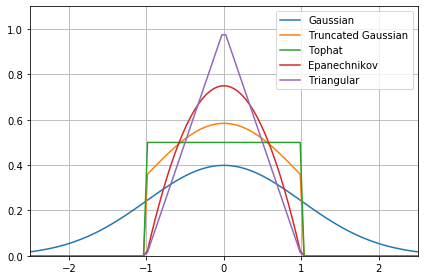

In [15]:
tmp_x = np.linspace(-2.5, 2.5, 100)

plt.plot(tmp_x, gaussian_kernel(0, tmp_x, 1), label='Gaussian')
plt.plot(tmp_x, truncnorm_kernel(0, tmp_x, 1), label='Truncated Gaussian')
plt.plot(tmp_x, tophat_kernel(0, tmp_x, 1), label='Tophat')
plt.plot(tmp_x, epanechnikov_kernel(0, tmp_x, 1), label='Epanechnikov')
plt.plot(tmp_x, triangle_kernel(0, tmp_x, 1), label='Triangular')

plt.legend()

plt.grid()

plt.ylim(0, 1.1)
plt.xlim(-2.5, 2.5)

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


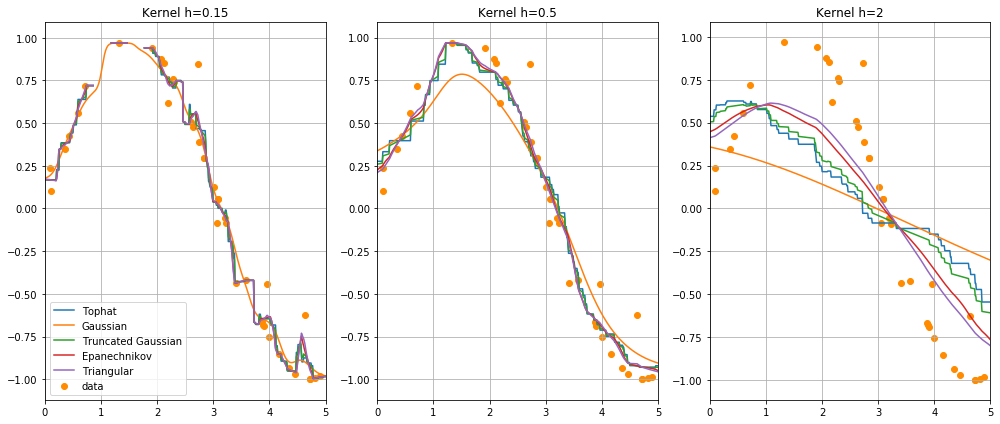

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(14,6))


np.random.seed(0)
X = np.sort(5 * np.random.rand(40))
T = np.linspace(0, 5, 500)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))


labels = ['Tophat', 'Gaussian', 'Truncated Gaussian', 'Epanechnikov', 'Triangular']
kernels = [tophat_kernel, gaussian_kernel, truncnorm_kernel, epanechnikov_kernel, triangle_kernel]
h_set = [0.15, 0.5, 2]
titles = ['Kernel h=0.15', 'Kernel h=0.5', 'Kernel h=2']

for k, h in enumerate(h_set):
    
    for j in range(len(labels)):
        y_ = np.zeros(len(T))
        for i in range(len(T)):
            weights = calc_weights(T[i], X, h, kernels[j])
            y_[i] = np.average(y, weights=weights)
        ax[k].plot(T, y_, label=labels[j])
        
    ax[k].set_title(titles[k])

    ax[k].scatter(X, y, color="darkorange", label="data")

ax[0].legend()

for a in ax:
    a.set_xlim(0, 5)
    a.grid()

plt.tight_layout()
plt.show()

### Discuss with your partner the differences between the different kernels

#### 5. Kernel with a variable scale
For many data sets, there are significant variations in the sparsity of data across the domain. Ideally, when data are more sparsely populated, one can adopt a larger kernel size, while more densely packed data ought to have a smaller kernel. The typical method here is to set the kernel size to be equal to the distance to the $k$-nearest neighbor.

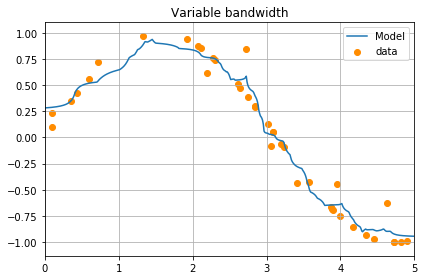

In [17]:
def epanechnikov_kernel_variable_bandwidth(x, x_set, h, k=5):
    
    dist = np.sort(np.abs(x-x_set))
    
    u = np.abs(x-x_set) / dist[k]
    
    kernel = np.zeros(len(x_set))    
    kernel[np.where(u < 1)[0]] = 3/4 * (1 - u[np.where(u < 1)[0]]**2)
    
    return kernel



y_ = np.zeros(len(T))
for i in range(len(T)):
    weights = calc_weights(T[i], X, 0.0, epanechnikov_kernel_variable_bandwidth)
    y_[i] = np.average(y, weights=weights)
plt.plot(T, y_, label='Model')

plt.title('Variable bandwidth')

plt.scatter(X, y, color="darkorange", label="data")

plt.legend()
plt.xlim(0, 5)
plt.grid()

plt.tight_layout()
plt.show()

### Regression: parametric methods

While kernel methods are non-parametric, regression methods are parametric: one first seeks to find a function $f(\vec{x})$ which best describes the dataset -- either locally or globally -- then evaluates that function at some new point $\vec{x}'$.

Since we've already gone through the math and defined the functions, we are ready to apply our methods. One of the nice things about regression methods is that we can properly incorporate error bars in our analysis.

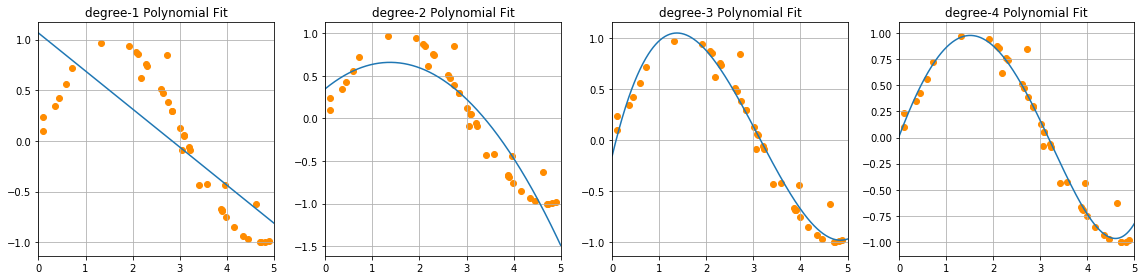

In [18]:
def calc_polynomial_fit(x_data, y_data, degree=2):
    
    # get data size
    N = len(x_data)

    # Construct matrices
    Y = np.matrix(y_data).T
    A = np.ones((N, degree+1))
    for k in range(degree+1):
        A[:,k] = x_data**k
    A = np.matrix(A)
    
    I = np.matrix(np.identity(N))
    
    # solve matrix math to obtain our slope and intercept
    model = inv(A.T * I * A) * (A.T * I * Y)
    
    return model


fig, ax = plt.subplots(1, 4, figsize=(16, 4))

degrees = [1, 2, 3, 4]
for i, a in enumerate(ax):

    degree = degrees[i]
    model = calc_polynomial_fit(X, y, degree=degree)

    model_x = np.linspace(0, 5, 500)
    model_y = np.zeros(len(model_x))
    for k in range(degree+1):
        model_y += model[k,0]*model_x**k

    a.plot(model_x, model_y)

    a.set_title('degree-%i Polynomial Fit'%degree)
    
    a.scatter(X, y, color="darkorange", label="data")

    a.set_xlim(0, 5)
    a.grid()


plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.


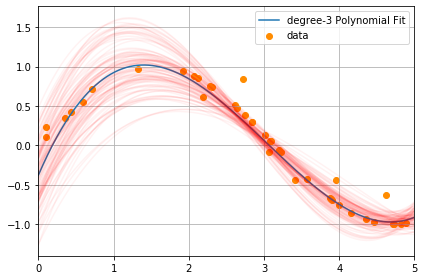

In [19]:
np.random.seed(0)
data_x = np.sort(5 * np.random.rand(40))
data_y = np.sin(data_x).ravel()

# Add noise to targets
data_y_err = 0.1*np.random.normal(size=40)
data_y += data_y_err



# Calculate and plot best fit model
degree = 3
model = calc_best_fit(data_x, data_y, data_y_err, degree=degree)

model_x = np.linspace(0, 5, 500)
model_y = np.zeros(len(model_x))
for k in range(degree+1):
    model_y += model[k,0]*model_x**k

plt.plot(model_x, model_y, label='degree-%i Polynomial Fit'%degree)



# Calculate and plot best fit model with uncertainties
model_cov = calc_uncertainties(data_x, data_y_err, degree=degree)
x_out = np.random.multivariate_normal(model.flatten(), model_cov, size=100)


# Plot lines
for i in np.arange(100):
    model_y = np.zeros(len(model_x))
    for k in range(degree+1):
        model_y += x_out[i,k]*model_x**k

    plt.plot(model_x, model_y, color='r', alpha=0.05)


plt.scatter(X, y, color="darkorange", label="data")

plt.legend()
plt.xlim(0, 5)
plt.grid()

plt.tight_layout()
plt.show()